# Autoencoder

In this work we will build simple and more complicated autoencoders on the MNIST dataset.

An autoencoder is a neural network that is trained to attempt to copy its input to its output. It has two parts :


- An encoder function $h_{\theta_{e}} : \mathcal{X} \rightarrow \mathcal{Z}$ that pushes the inputs $x$ in a smaller dimensional space.
- A decoder function $g_{\theta_{d}} : \mathcal{Z} \rightarrow \mathcal{X}$ that reconstructs from the low dimensional space to the initial space

Very generally autoencoders aim at solving  : 

$$\underset{\theta_{e},\theta_{d}}{\text{min}} \ \underset{x \sim \mathbb{P}_{r}}{\mathbb{E}}[L(x,g_{\theta_{d}},h_{\theta_{e}})]$$

<img src="imgs/autoencoder.png" alt="Drawing" style="width: 500px;"/>



In [1]:
from keras.layers import Input, Dense
from keras.models import Model
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
from matplotlib import cm
def graph_colors(nx_graph):
    #cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["blue","red"])
    #cm1 = mcol.Colormap('viridis')

    cnorm = mcol.Normalize(vmin=0,vmax=9)
    cpick = cm.ScalarMappable(norm=cnorm,cmap='Set1')
    cpick.set_array([])
    val_map = {}
    for k,v in nx.get_node_attributes(nx_graph,'attr').items():
        #print(v)
        val_map[k]=cpick.to_rgba(v)
    #print(val_map)
    colors=[]
    for node in nx_graph.nodes():
        #print(node,val_map.get(str(node), 'black'))
        colors.append(val_map[node])
    return colors

Using TensorFlow backend.


Load the MNIST dataset using the following command:

In [2]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


##### 1 Write a function that builds a simple autoencoder 

The autoencoder must have a simple Dense layer with relu activation. The number of node of the dense layer is a parameter of the function.

The function must return the entire autoencoder model as well as the encoder and the decoder.
You will need the following classes:
- [Input](https://keras.io/layers/core/)
- [Dense](https://keras.io/layers/core/)
- [Model](https://keras.io/models/model/)

In [3]:
def build_simple_autoencoder(encoding_dim=32):
    input_img = Input(shape=(784,))
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    encoded_input = Input(shape=(encoding_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')   
    return autoencoder,encoder,decoder

##### 2. Build the autoencoder with a embedding size of 32 and print the number of parameters of the model. What do they relate to ?


In [4]:
autoencoder,encoder,decoder=build_simple_autoencoder(32)

In [5]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [6]:
2*784*32+784+32

50992

##### 3. Fit the autoencoder using 32 epochs with a batch size of 256

In [7]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.3554 - val_loss: 0.2719
Epoch 2/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.2652 - val_loss: 0.2550
Epoch 3/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.2450 - val_loss: 0.2330
Epoch 4/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.2248 - val_loss: 0.2149
Epoch 5/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.2096 - val_loss: 0.2023
Epoch 6/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.1989 - val_loss: 0.1928
Epoch 7/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.1901 - val_loss: 0.1847
Epoch 8/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.1825 - val_loss: 0.1776
Epoch 9/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.1761 - val_loss: 0.1718
Epoch

##### 4. Using the history module of the autoencoder write a function that plots the learning curves with respect to the epochs on the train and test set. What can you say about these learning curves ? Give also the last loss on the test set

In [8]:
def plot_learning_curves(autoencoder):
    history=autoencoder.history
    # summarize history for loss
    plt.figure(figsize=(7,7))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

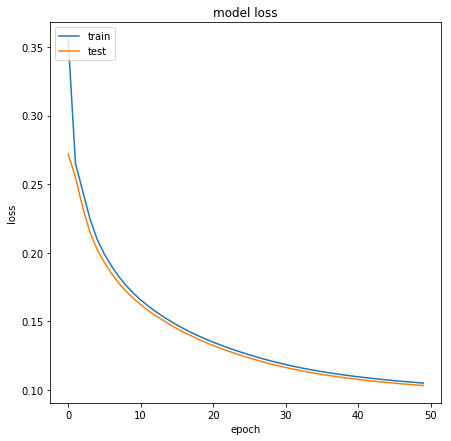

In [9]:
plot_learning_curves(autoencoder)

In [10]:
autoencoder.history.history['val_loss'][::-1][0]

0.10321707379817963

##### 5. Write a function that plots a fix number of example of the original images on the test as well as their reconstruction

In [11]:
def plot_reconstructed_images(encoder,decoder,x_test):
   # encode and decode some digits
    # note that we take them from the *test* set
    encoded_imgs = encoder.predict(x_test)
    print('Mean encoded image : %.2f' %encoded_imgs.mean())
    decoded_imgs = decoder.predict(encoded_imgs)
    n = 10  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Mean encoded image : 7.37


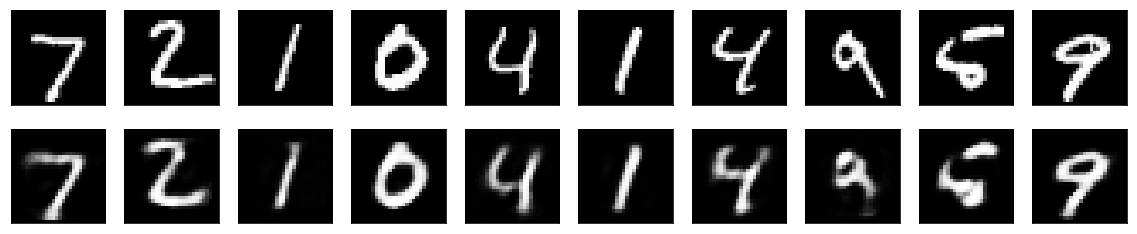

In [12]:
plot_reconstructed_images(encoder,decoder,x_test)

### Nearest neighbours graphs
The goal of this part is to visualize the neighbours graph in the embedding. It corresponds the the graph of the k-nearest neighbours using the euclidean distance of points the element in the embedding

The function that computes the neighbors graphs can be found here 

In [13]:
from sklearn.neighbors import kneighbors_graph
import networkx as nx

In [14]:
def plot_nearest_neighbour_graph(encoder,x_test,y_test,ntest=100,p=3): #to explain
    X=encoder.predict(x_test[1:ntest])
    y=y_test[1:ntest]
    A = kneighbors_graph(X, p, mode='connectivity', include_self=True)
    G=nx.from_numpy_array(A.toarray())
    nx.set_node_attributes(G,dict(zip(range(ntest),y)),'attr')
    fig, ax = plt.subplots(figsize=(10,10))
    pos=nx.layout.kamada_kawai_layout(G)
    nx.draw(G,pos=pos
            ,with_labels=True
            ,labels=nx.get_node_attributes(G,'attr')
            ,node_color=graph_colors(G))
    plt.tight_layout()
    plt.title('Nearest Neighbours Graph',fontsize=15)
    plt.show()

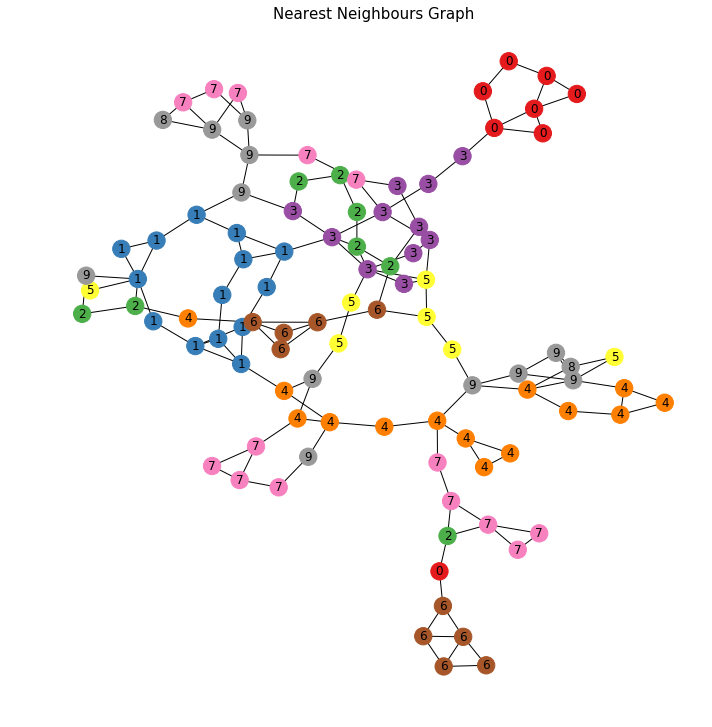

In [15]:
plot_nearest_neighbour_graph(encoder,x_test,y_test,ntest=100,p=3)

We can also plot a 2D MDS of the embedding space: 

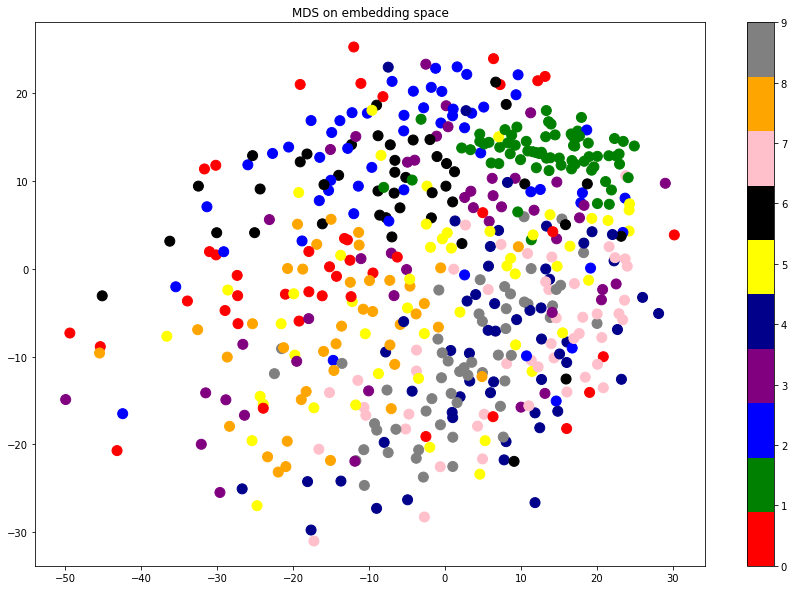

In [16]:
from sklearn.manifold import MDS
import matplotlib

ntest=500
mds=MDS(n_components=2)
X=encoder.predict(x_test[1:ntest])
X_dim2=mds.fit_transform(X)
colors = ['red','green','blue','purple','darkblue','yellow','black','pink','orange','grey']
label=y_test[1:ntest]
plt.figure(figsize=(15,10))
plt.scatter(X_dim2[:,0]
            ,X_dim2[:,1]
            ,c=label,cmap=matplotlib.colors.ListedColormap(colors)
           ,s=100)
plt.colorbar()
plt.title('MDS on embedding space')
plt.show()

### Reduce the dimension of the embedding

##### 6. Rerun the previous example using an embedding dimension of 16

In [17]:
autoencoder,encoder,decoder=build_simple_autoencoder(16)

In [18]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                12560     
_________________________________________________________________
dense_4 (Dense)              (None, 784)               13328     
Total params: 25,888
Trainable params: 25,888
Non-trainable params: 0
_________________________________________________________________


In [19]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.3596 - val_loss: 0.2723
Epoch 2/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.2664 - val_loss: 0.2574
Epoch 3/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.2476 - val_loss: 0.2361
Epoch 4/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.2277 - val_loss: 0.2181
Epoch 5/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.2129 - val_loss: 0.2056
Epoch 6/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.2021 - val_loss: 0.1960
Epoch 7/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1935 - val_loss: 0.1885
Epoch 8/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1867 - val_loss: 0.1824
Epoch 9/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1814 - val_loss: 0.1777
Epoch

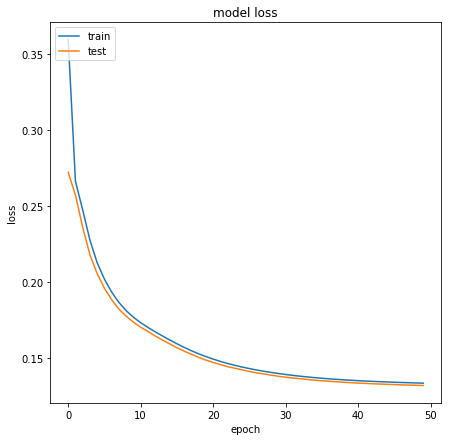

In [20]:
plot_learning_curves(autoencoder)

In [21]:
autoencoder.history.history['val_loss'][::-1][0]

0.13217485872507095

Mean encoded image : 9.94


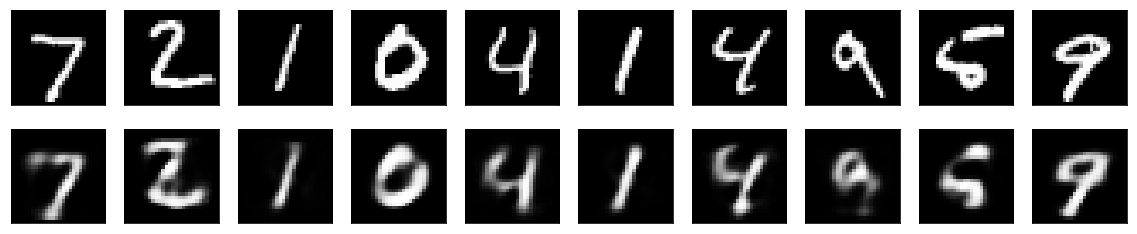

In [22]:
plot_reconstructed_images(encoder,decoder,x_test)

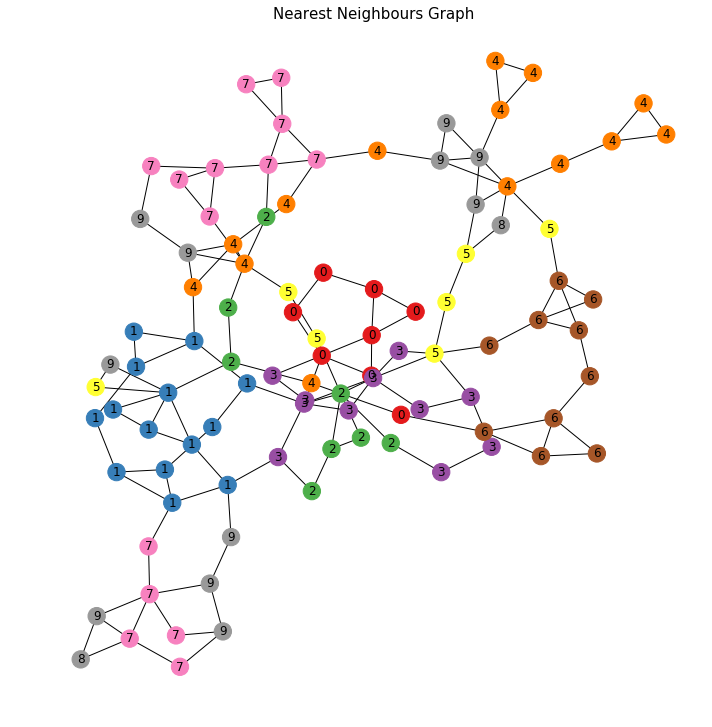

In [23]:
plot_nearest_neighbour_graph(encoder,x_test,y_test,ntest=100,p=3)

## Adding sparsity


##### Question 7.  Add sparisity over the weights

In this part we will add sparisity over the weights on the embedding layer. Write a function that build such a autoencoder (using a l1 regularization with a configurable regularization parameter and using the same autoencoder architecture that before)

You will use the [regularizers](https://keras.io/regularizers/) module.

In [24]:
from keras import regularizers

In [25]:
def build_regularized_autoencoder(encoding_dim=32,regul=10e-5):
    
    # this is the size of our encoded representations
    encoding_dim = encoding_dim  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

    # this is our input placeholder
    input_img = Input(shape=(784,))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu',activity_regularizer=regularizers.l1(regul))(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(784, activation='sigmoid')(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)
    # this model maps an input to its encoded representation
    encoder = Model(input_img, encoded)
    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    return autoencoder,encoder,decoder

In [26]:
autoencoder,encoder,decoder=build_regularized_autoencoder()

In [27]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.6731 - val_loss: 0.6484
Epoch 2/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.6284 - val_loss: 0.6090
Epoch 3/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.5916 - val_loss: 0.5749
Epoch 4/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.5598 - val_loss: 0.5454
Epoch 5/50
60000/60000 [==============================] - 2s 31us/step - loss: 0.5323 - val_loss: 0.5198
Epoch 6/50
60000/60000 [==============================] - 2s 31us/step - loss: 0.5084 - val_loss: 0.4975
Epoch 7/50
60000/60000 [==============================] - 2s 31us/step - loss: 0.4875 - val_loss: 0.4780
Epoch 8/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.4692 - val_loss: 0.4609
Epoch 9/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.4531 - val_loss: 0.4457
Epoch

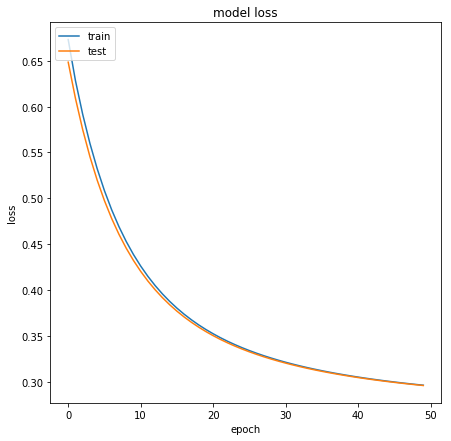

In [28]:
plot_learning_curves(autoencoder)

In [29]:
autoencoder.history.history['val_loss'][::-1][0]

0.2960067131519318

Mean encoded image : 0.00


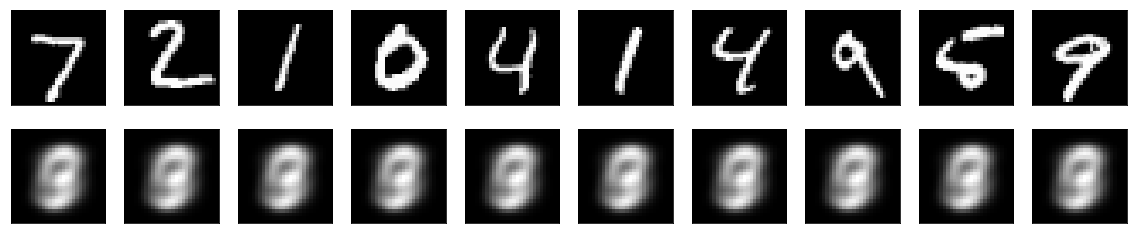

In [30]:
plot_reconstructed_images(encoder,decoder,x_test)

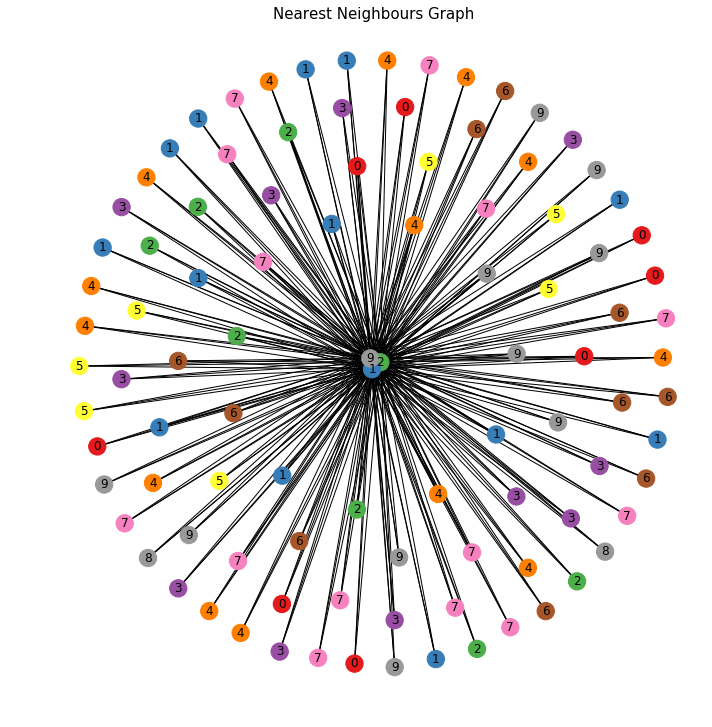

In [31]:
plot_nearest_neighbour_graph(encoder,x_test,y_test,ntest=100,p=3)

The regularization is too strong

In [32]:
autoencoder,encoder,decoder=build_regularized_autoencoder(regul=10e-7)

In [33]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.3803 - val_loss: 0.2894
Epoch 2/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.2820 - val_loss: 0.2729
Epoch 3/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.2640 - val_loss: 0.2530
Epoch 4/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.2458 - val_loss: 0.2366
Epoch 5/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.2314 - val_loss: 0.2238
Epoch 6/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.2200 - val_loss: 0.2139
Epoch 7/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.2116 - val_loss: 0.2068
Epoch 8/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.2052 - val_loss: 0.2011
Epoch 9/50
60000/60000 [==============================] - 2s 29us/step - loss: 0.2000 - val_loss: 0.1962
Epoch

Mean encoded image : 1.96


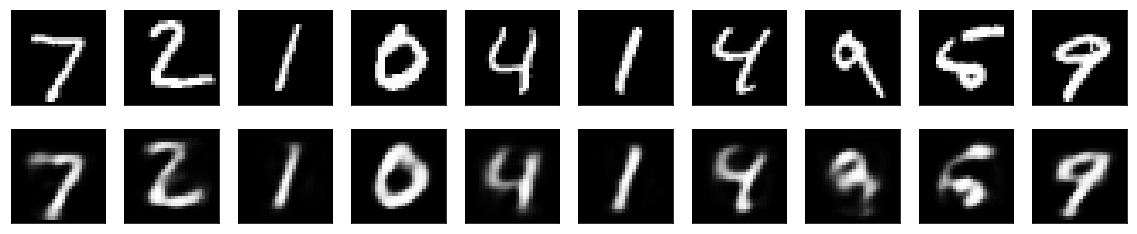

In [34]:
plot_reconstructed_images(encoder,decoder,x_test)

The mean of the encoded image is less than before -> due to the sparsity

# Deep autoencoder

In [35]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

##### Question 8. Use the following deep autoencoder to rerun the previous example. What can you say about the quality of the autoencoding ?

In [36]:
def build_deep_autoencoder(encoding_dim=32):
    

    input_img = Input(shape=(784,))
    encoded = Dense(128, activation='relu')(input_img)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(encoding_dim, activation='relu', name="embedding_layer")(encoded)

    encoder=Model(input_img, encoded)

    
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(784, activation='sigmoid')(decoded)
    
    autoencoder = Model(input_img, decoded)
    

    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
    
    return autoencoder,encoder

In [37]:
autoencoder,encoder=build_deep_autoencoder()

In [38]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
embedding_layer (Dense)      (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_12 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_13 (Dense)             (None, 784)               101136    
Total para

In [39]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 4s 72us/step - loss: 0.3573 - val_loss: 0.2655
Epoch 2/100
60000/60000 [==============================] - 3s 56us/step - loss: 0.2594 - val_loss: 0.2550
Epoch 3/100
60000/60000 [==============================] - 4s 61us/step - loss: 0.2462 - val_loss: 0.2368
Epoch 4/100
60000/60000 [==============================] - 3s 58us/step - loss: 0.2279 - val_loss: 0.2206
Epoch 5/100
60000/60000 [==============================] - 3s 54us/step - loss: 0.2157 - val_loss: 0.2093
Epoch 6/100
60000/60000 [==============================] - 3s 57us/step - loss: 0.2035 - val_loss: 0.1969
Epoch 7/100
60000/60000 [==============================] - 3s 51us/step - loss: 0.1948 - val_loss: 0.1899
Epoch 8/100
60000/60000 [==============================] - 3s 52us/step - loss: 0.1856 - val_loss: 0.1822
Epoch 9/100
60000/60000 [==============================] - 3s 49us/step - loss: 0.1782 - val_loss: 0.1

60000/60000 [==============================] - 3s 47us/step - loss: 0.1060 - val_loss: 0.1041
Epoch 78/100
60000/60000 [==============================] - 3s 42us/step - loss: 0.1056 - val_loss: 0.1047
Epoch 79/100
60000/60000 [==============================] - 3s 43us/step - loss: 0.1054 - val_loss: 0.1053
Epoch 80/100
60000/60000 [==============================] - 3s 42us/step - loss: 0.1051 - val_loss: 0.1032
Epoch 81/100
60000/60000 [==============================] - 3s 43us/step - loss: 0.1049 - val_loss: 0.1045
Epoch 82/100
60000/60000 [==============================] - 3s 43us/step - loss: 0.1046 - val_loss: 0.1044
Epoch 83/100
60000/60000 [==============================] - 3s 44us/step - loss: 0.1044 - val_loss: 0.1065
Epoch 84/100
60000/60000 [==============================] - 3s 44us/step - loss: 0.1040 - val_loss: 0.1039
Epoch 85/100
60000/60000 [==============================] - 3s 42us/step - loss: 0.1039 - val_loss: 0.1019
Epoch 86/100
60000/60000 [========================

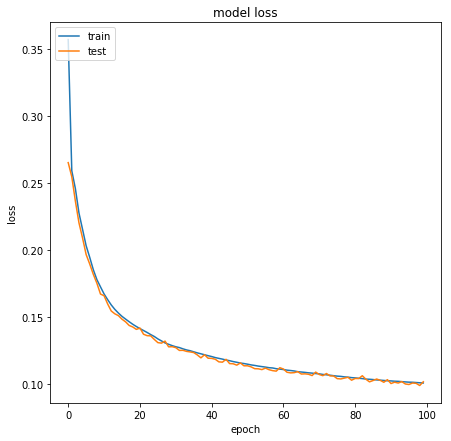

In [40]:
plot_learning_curves(autoencoder)

In [41]:
autoencoder.history.history['val_loss'][::-1][0]

0.10199022599458694

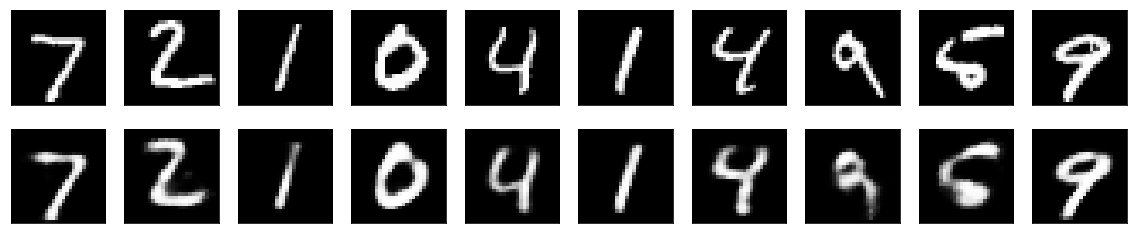

In [42]:
decoded_imgs = autoencoder.predict(x_test)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

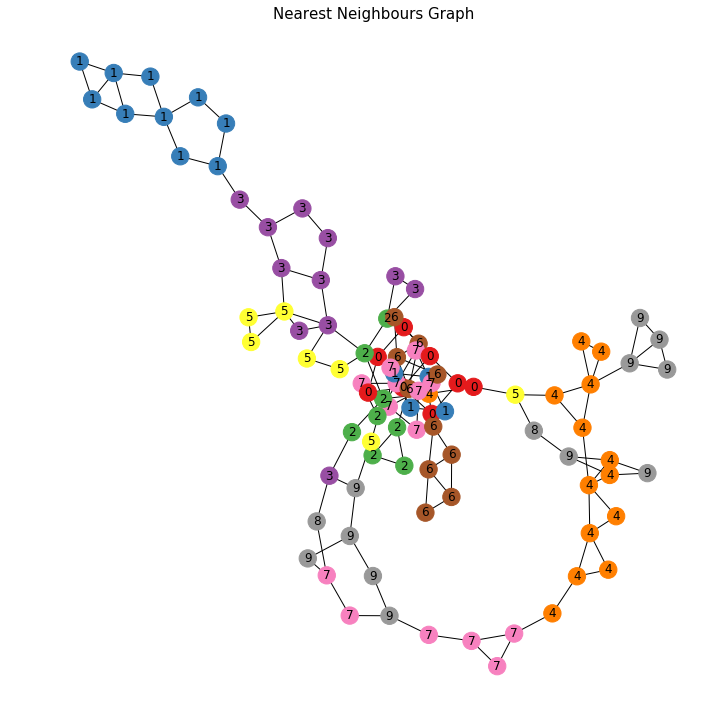

In [43]:
plot_nearest_neighbour_graph(encoder,x_test,y_test,ntest=100,p=3)

# Convolutionnal autoencoder

##### Question 8. Use the following convolutional autoencoder to rerun the previous example. What can you say about the quality of the autoencoding ?

In [44]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K


def build_conv_autoencoder():
    input_img = Input(shape=(28, 28, 1))

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    encoder= Model(input_img, encoded)

    # at this point the representation is (7, 7, 32)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    
    return autoencoder,encoder

In [45]:
autoencoder,encoder=build_conv_autoencoder()

In [46]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [47]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 81s 1ms/step - loss: 0.1266 - val_loss: 0.0910
Epoch 2/10
60000/60000 [==============================] - 79s 1ms/step - loss: 0.0851 - val_loss: 0.0822
Epoch 3/10
60000/60000 [==============================] - 78s 1ms/step - loss: 0.0797 - val_loss: 0.0765
Epoch 4/10
60000/60000 [==============================] - 78s 1ms/step - loss: 0.0769 - val_loss: 0.0753
Epoch 5/10
60000/60000 [==============================] - 79s 1ms/step - loss: 0.0750 - val_loss: 0.0741
Epoch 6/10
60000/60000 [==============================] - 87s 1ms/step - loss: 0.0738 - val_loss: 0.0743
Epoch 7/10
60000/60000 [==============================] - 81s 1ms/step - loss: 0.0728 - val_loss: 0.0710
Epoch 8/10
60000/60000 [==============================] - 80s 1ms/step - loss: 0.0721 - val_loss: 0.0714
Epoch 9/10
60000/60000 [==============================] - 80s 1ms/step - loss: 0.0715 - val_loss: 0.0705
Epoch

In [48]:
autoencoder.history.history['val_loss'][::-1][0]

0.07013918192386627

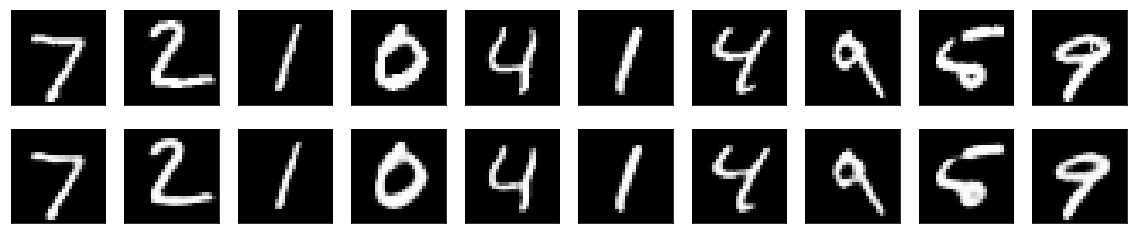

In [49]:
decoded_imgs = autoencoder.predict(x_test)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

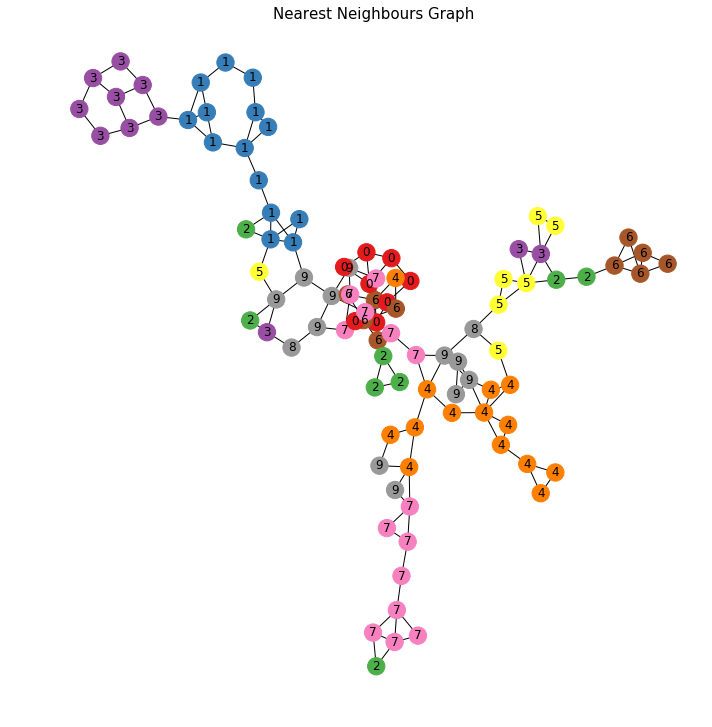

In [50]:
X=encoder.predict(x_test[1:100])
X=X.reshape((99,7*7*32))
y=y_test[1:100]
A = kneighbors_graph(X, 3, mode='connectivity', include_self=True)
G=nx.from_numpy_array(A.toarray())
nx.set_node_attributes(G,dict(zip(range(100),y)),'attr')
fig, ax = plt.subplots(figsize=(10,10))
pos=nx.layout.kamada_kawai_layout(G)
nx.draw(G,pos=pos
        ,with_labels=True
        ,labels=nx.get_node_attributes(G,'attr')
        ,node_color=graph_colors(G))
plt.tight_layout()
plt.title('Nearest Neighbours Graph',fontsize=15)
plt.show()

# Application to denoising

In this part we will add some noise to the original data to see how the auto-encoding process denoises our data.

In [51]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [52]:
autoencoder,encoder=build_conv_autoencoder()

In [53]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test)
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 81s 1ms/step - loss: 0.1765 - val_loss: 0.1274
Epoch 2/20
60000/60000 [==============================] - 82s 1ms/step - loss: 0.1195 - val_loss: 0.1112
Epoch 3/20
60000/60000 [==============================] - 83s 1ms/step - loss: 0.1119 - val_loss: 0.1069
Epoch 4/20
60000/60000 [==============================] - 80s 1ms/step - loss: 0.1082 - val_loss: 0.1045
Epoch 5/20
60000/60000 [==============================] - 79s 1ms/step - loss: 0.1059 - val_loss: 0.1072
Epoch 6/20
60000/60000 [==============================] - 80s 1ms/step - loss: 0.1045 - val_loss: 0.1029
Epoch 7/20
60000/60000 [==============================] - 80s 1ms/step - loss: 0.1031 - val_loss: 0.1022
Epoch 8/20
60000/60000 [==============================] - 80s 1ms/step - loss: 0.1022 - val_loss: 0.1002
Epoch 9/20
60000/60000 [==============================] - 80s 1ms/step - loss: 0.1014 - val_loss: 0.1007
Epoch

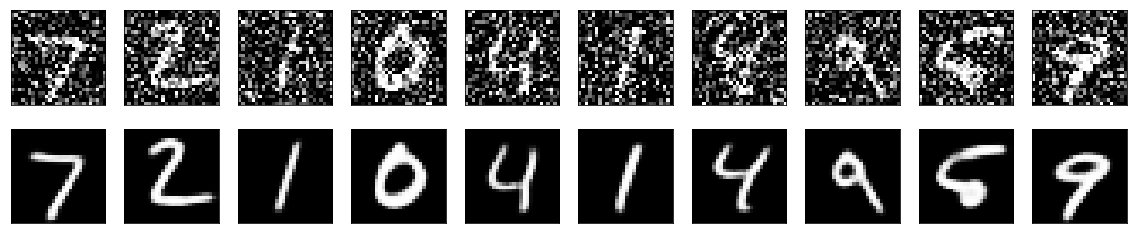

In [54]:
decoded_imgs = autoencoder.predict(x_test)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()